# Assess disease progression predictions on diabetes data

This notebook demonstrates the use of the `responsibleai` API to assess a regression trained on diabetes progression data. It walks through the API calls necessary to create a widget with model analysis insights, then guides a visual analysis of the model.

* [Launch Responsible AI Toolbox](#Launch-Responsible-AI-Toolbox)
    * [Train a Model](#Train-a-Model)
    * [Create Model and Data Insights](#Create-Model-and-Data-Insights)
* [Assess Your Model](#Assess-Your-Model)
    * [Aggregate Analysis](#Aggregate-Analysis)
    * [Individual Analysis](#Individual-Analysis)

## Launch Responsible AI Toolbox

The following section examines the code necessary to create datasets and a model. It then generates insights using the `responsibleai` API that can be visually analyzed.

### Train a Model
*The following section can be skipped. It loads a dataset and trains a model for illustrative purposes.*

In [ ]:
import shap
import sklearn
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

First, load the diabetes dataset and specify the different types of features. Then, clean it and put it into a dataframe with named columns.

In [ ]:
data = sklearn.datasets.load_diabetes()
target_feature = 'y'
continuous_features = data.feature_names
data_df = pd.DataFrame(data.data, columns=data.feature_names)

After loading and cleaning the data, split the datapoints into training and test sets. Assemble separate datasets for the full sample and the test data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_df, data.target, test_size=0.2, random_state=7)

train_data = X_train.copy()
test_data = X_test.copy()
train_data[target_feature] = y_train
test_data[target_feature] = y_test
data.feature_names

Train a nearest-neighbors classifier on the training data.

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

### Create Model and Data Insights

In [ ]:
from raiwidgets import ModelAnalysisDashboard
from responsibleai import ModelAnalysis

To use Responsible AI Toolbox, initialize a ModelAnalysis object upon which different components can be loaded.

ModelAnalysis accepts the model, the train dataset, the test dataset, the target feature string, the task type string, and a list of strings of categorical feature names as its arguments.

In [ ]:
model_analysis = ModelAnalysis(model, train_data, test_data, target_feature, 'regression',
                               categorical_features=[])

Add the components of the toolbox that are focused on model assessment.

In [ ]:
# Interpretability
model_analysis.explainer.add()
# Error Analysis
model_analysis.error_analysis.add()
# Counterfactuals: accepts total number of counterfactuals to generate, the range that their label should fall under, 
# and a list of strings of categorical feature names
model_analysis.counterfactual.add(total_CFs=20, desired_range=[50, 120])

Once all the desired components have been loaded, compute insights on the test set.

In [ ]:
model_analysis.compute()

Finally, visualize and explore the model insights. Use the resulting widget or follow the link to view this in a new tab.

In [ ]:
ModelAnalysisDashboard(model_analysis)

## Assess Your Model

### Aggregate Analysis

Upon opening the dashboard widget, the Error Analysis component is displayed at the top. The tree map view of this component visualizes the cohort breakdown of error in nodes.

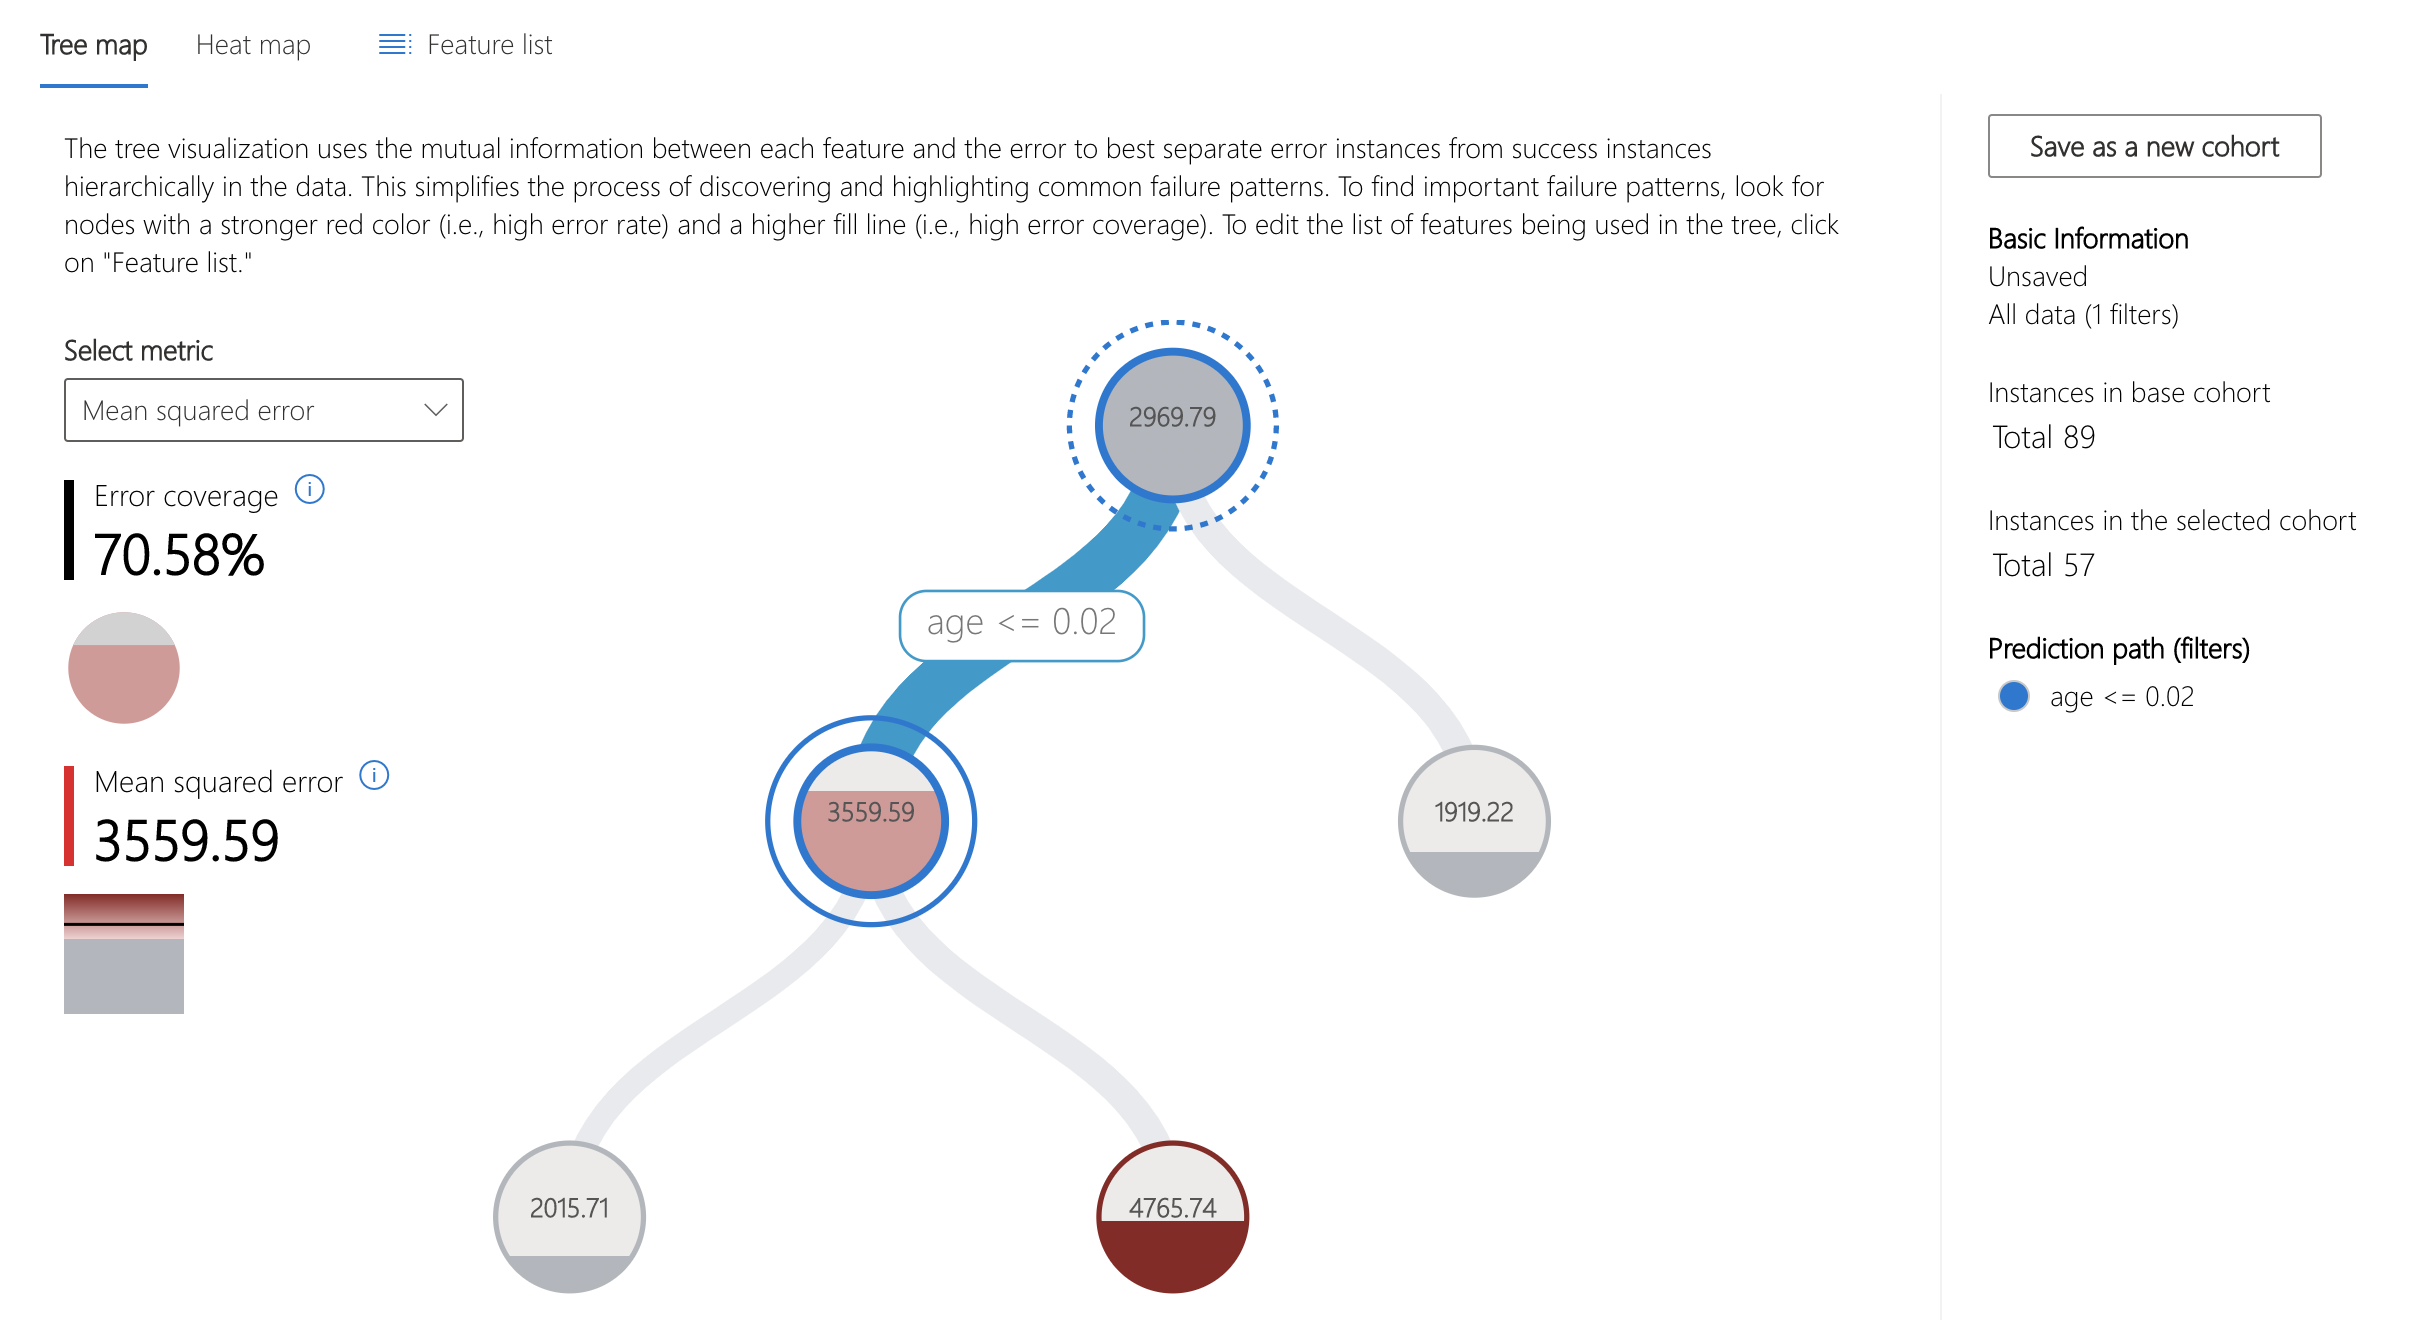

For this model, over 70% of the error is concentrated in datapoints whose age feature is less than 0.02. Note that this value has been mean-centered and scaled by the number of samples * standard deviation.

Let's explore this cohort further.

First, save the cohort of interest. This can be done by clicking "Save as a new cohort" on the ride side panel.

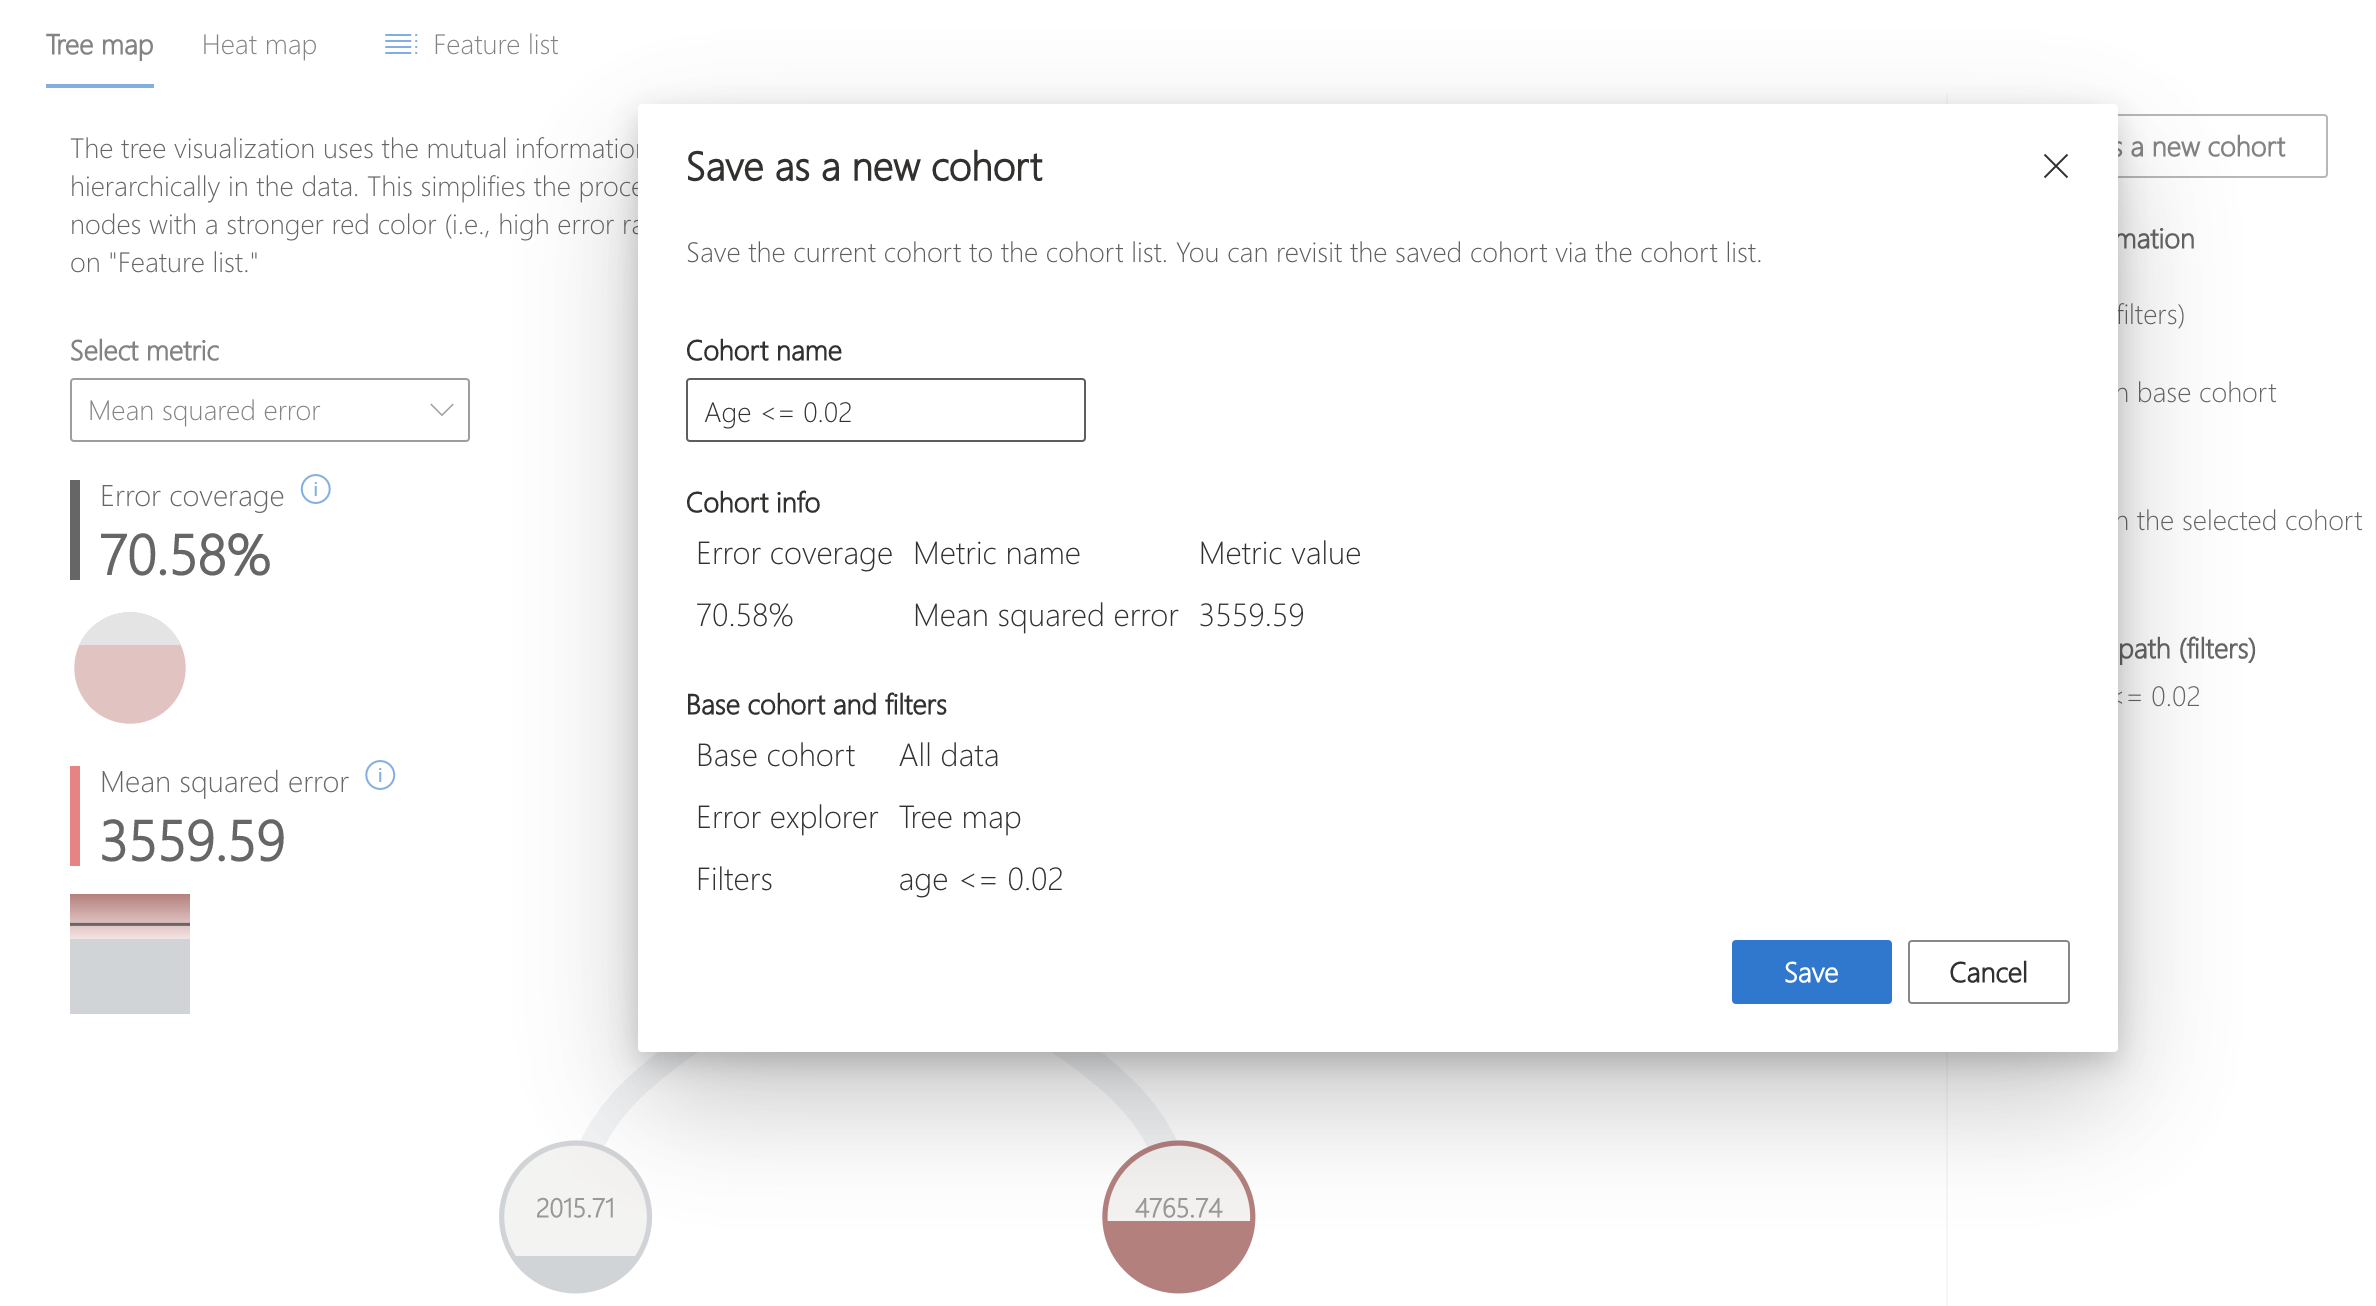

Then, click "Switch global cohort" and select the recently saved cohort to focus analysis on.

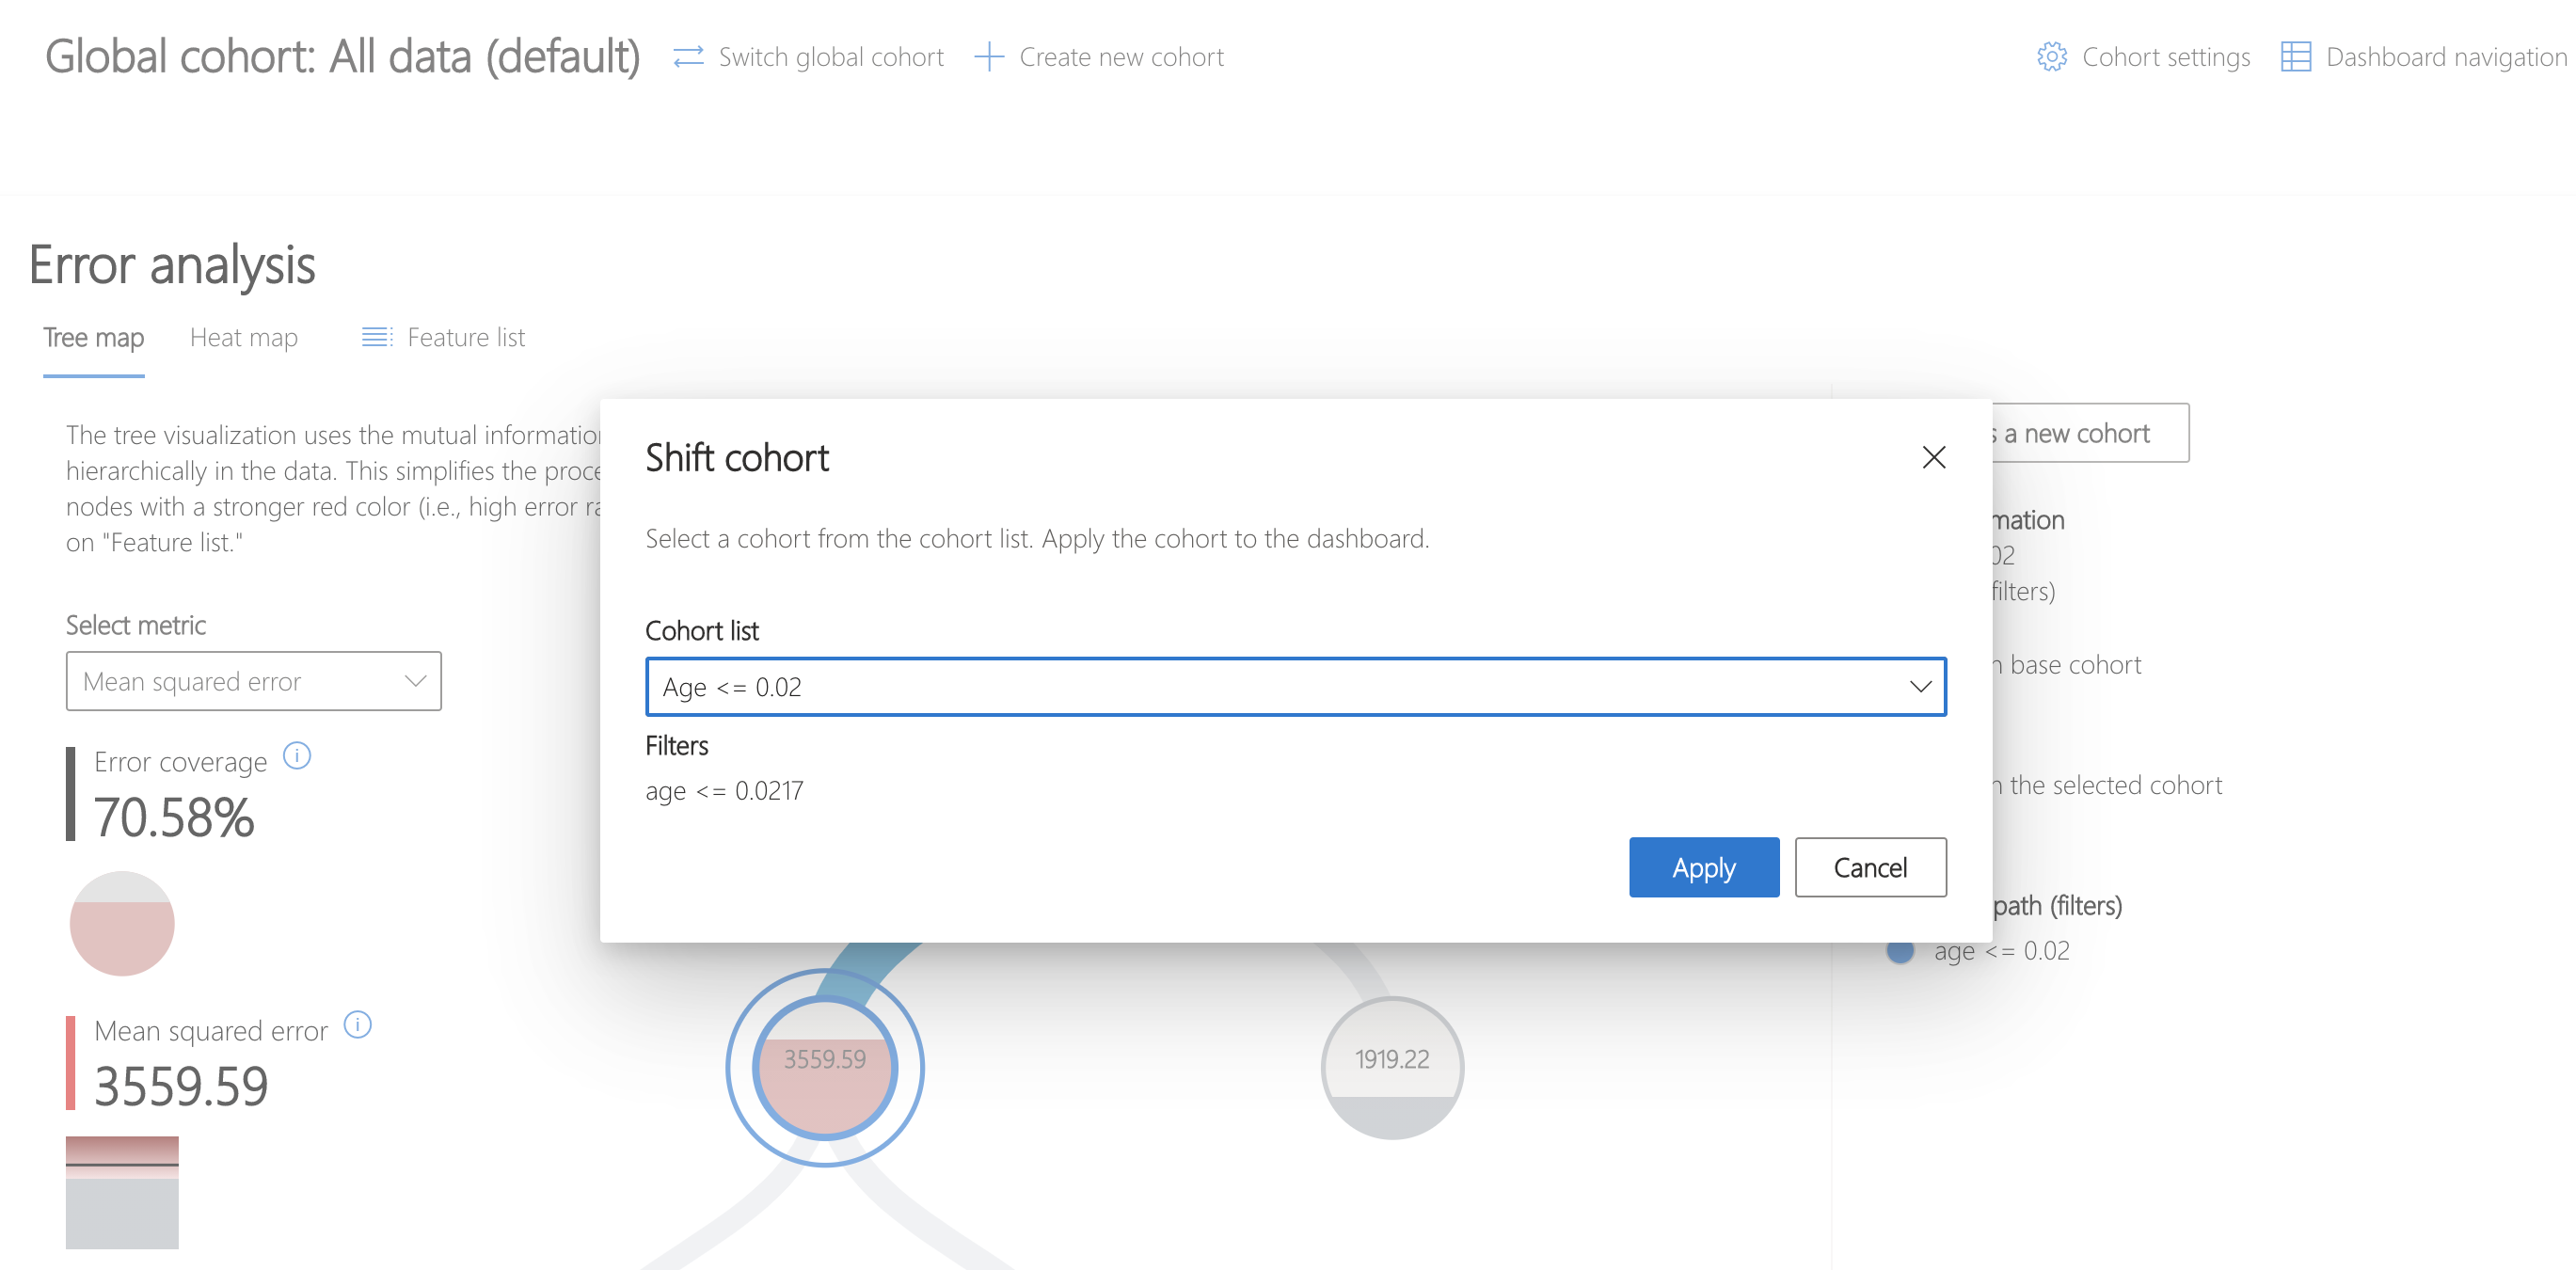

The heatmap can be used to understand this cohort further by visualizing the error rates of subcohorts. Investigating feature `s5`, [thought to represent the log of the serum triglycerides level](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset), shows a marked difference in error rates between bins of data.

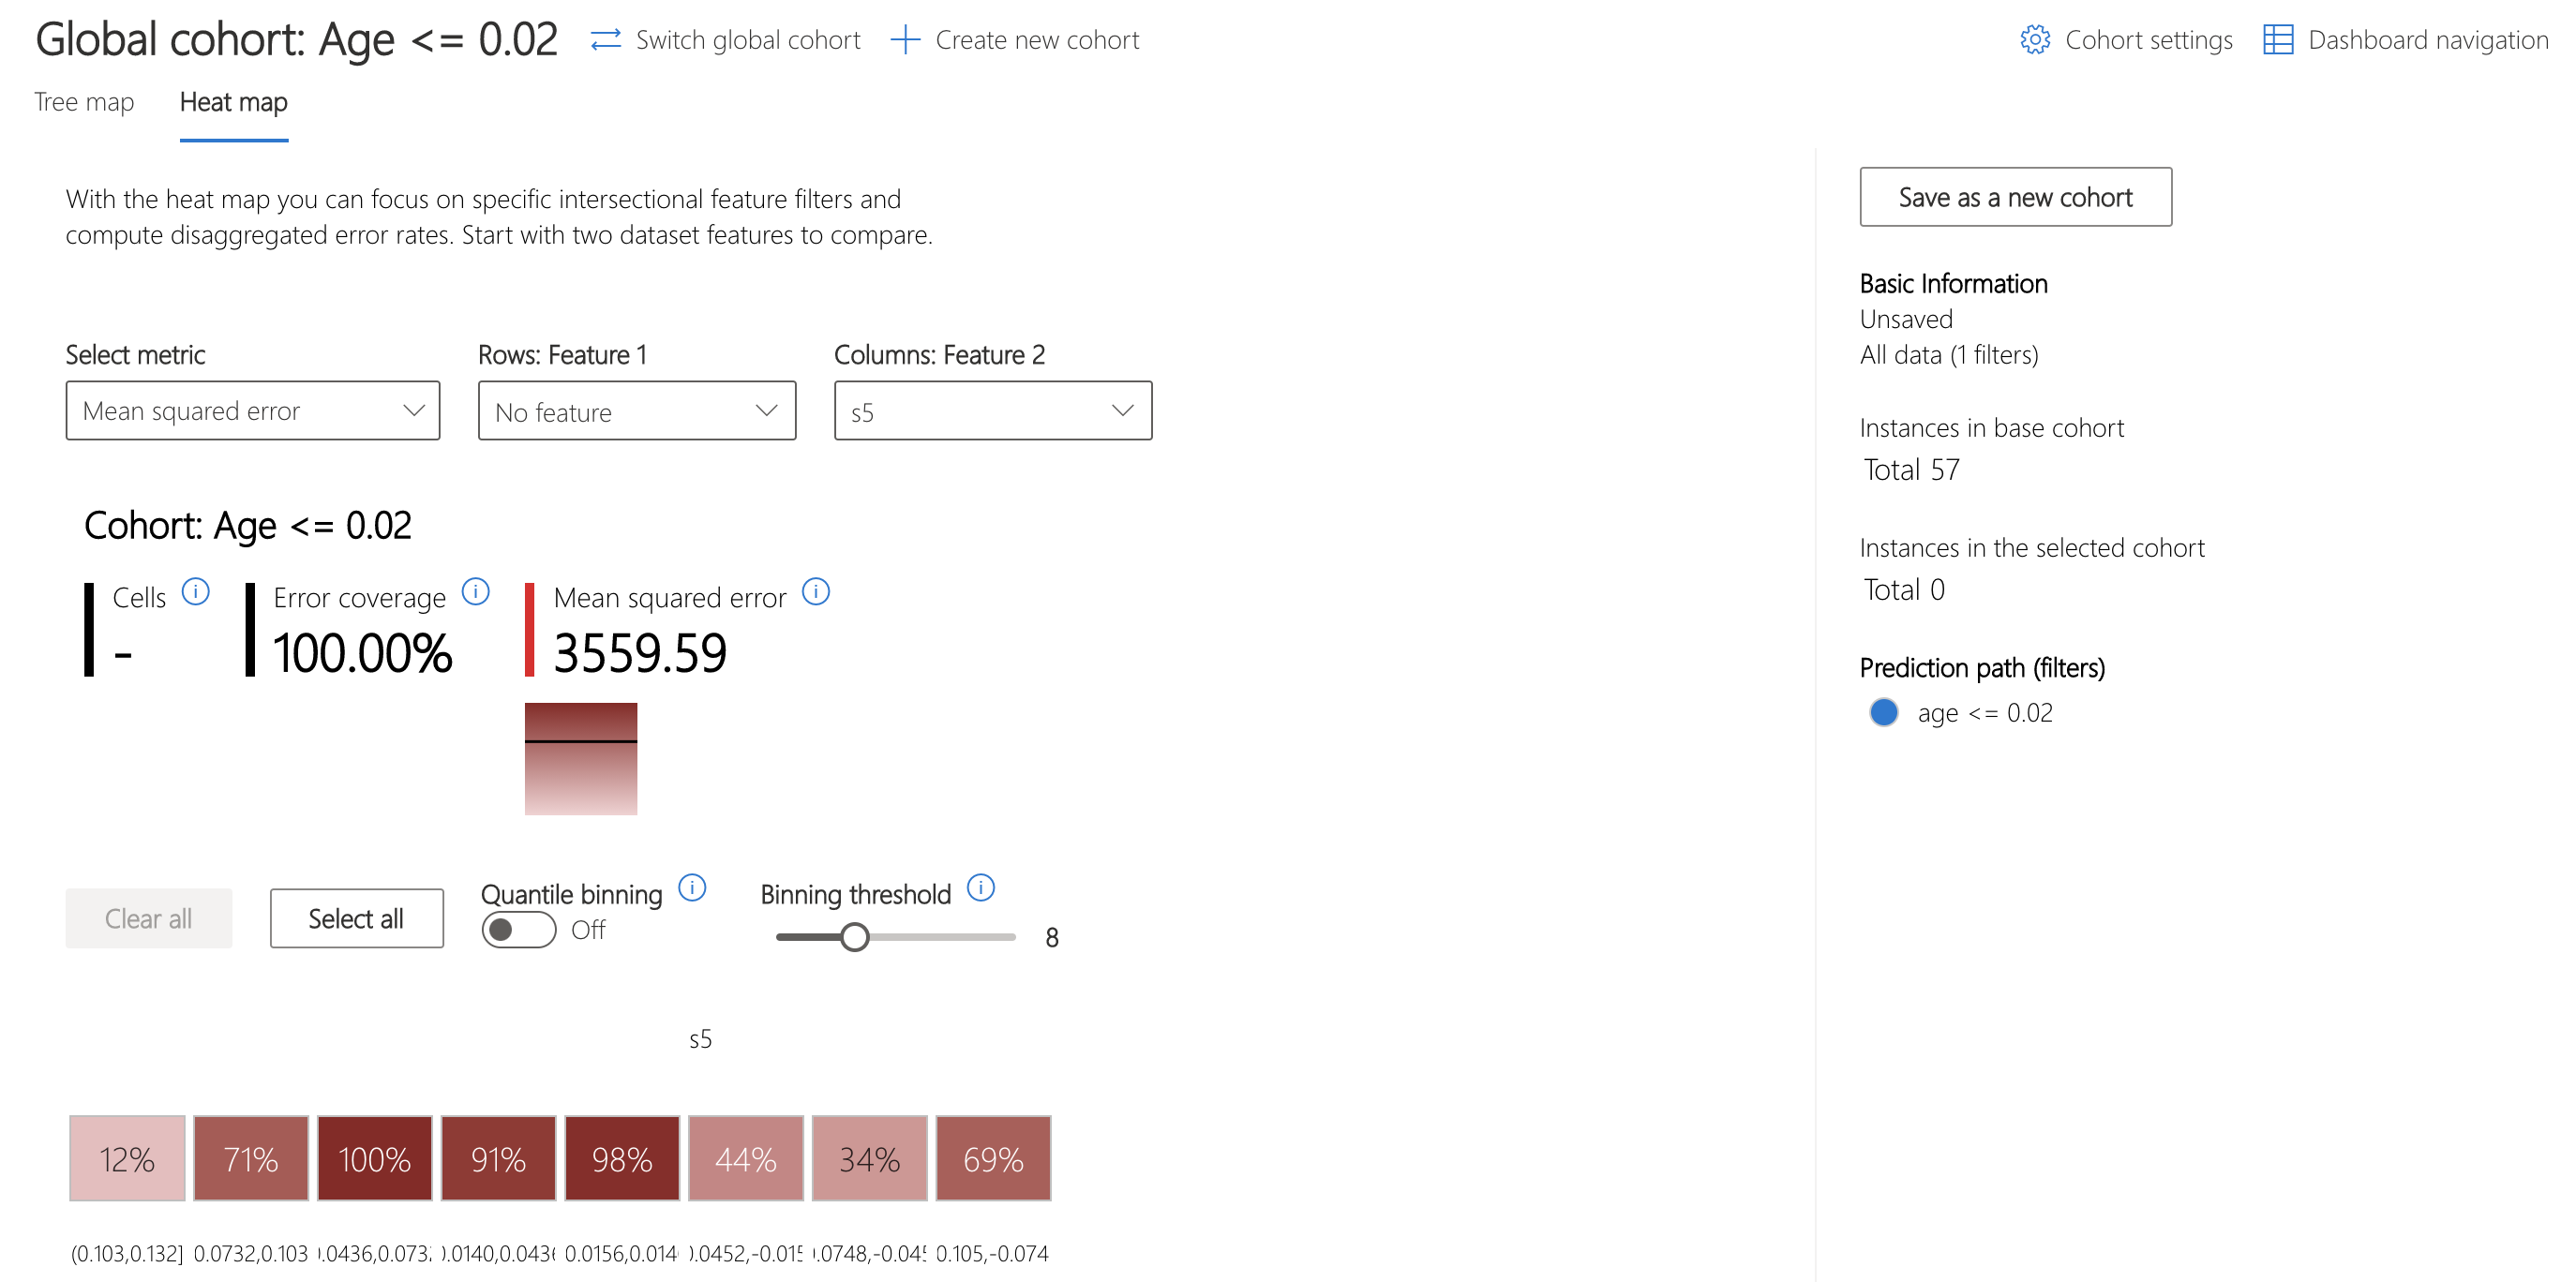

Let's use the Model Overview component to examine how the distribution of error in the overall dataset, stratified by `s5`, compares.

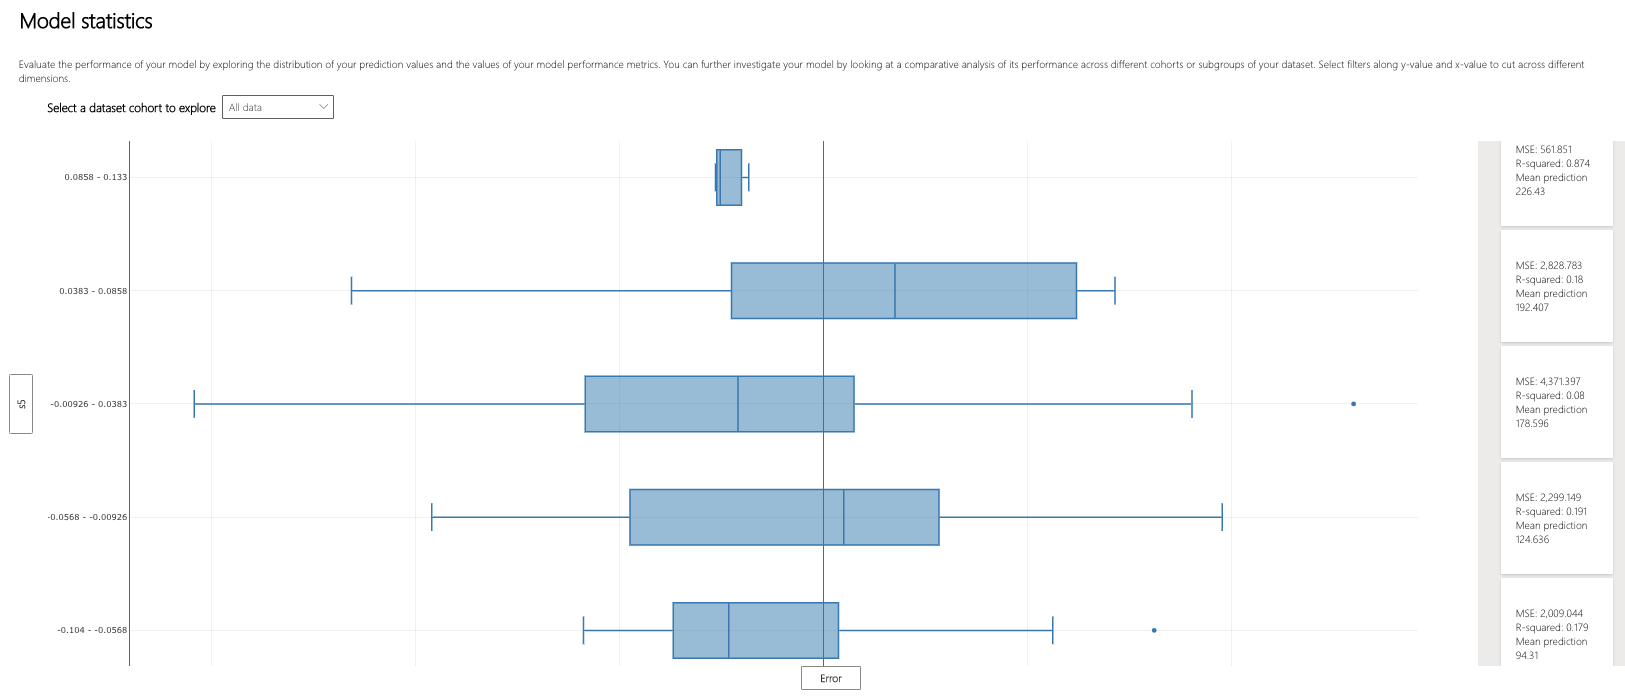

It appears that the three middle bins of the five have the largest interquartile ranges of error. How might the error patterns relate to the underlying distribution of the data?

The Data Explorer component can help to visualize how data is spread across these bins. Interestingly, the bins with the most varied error also have the most datapoints. Intuitively, it makes sense that the more points in the bin, the more variation of error within it.

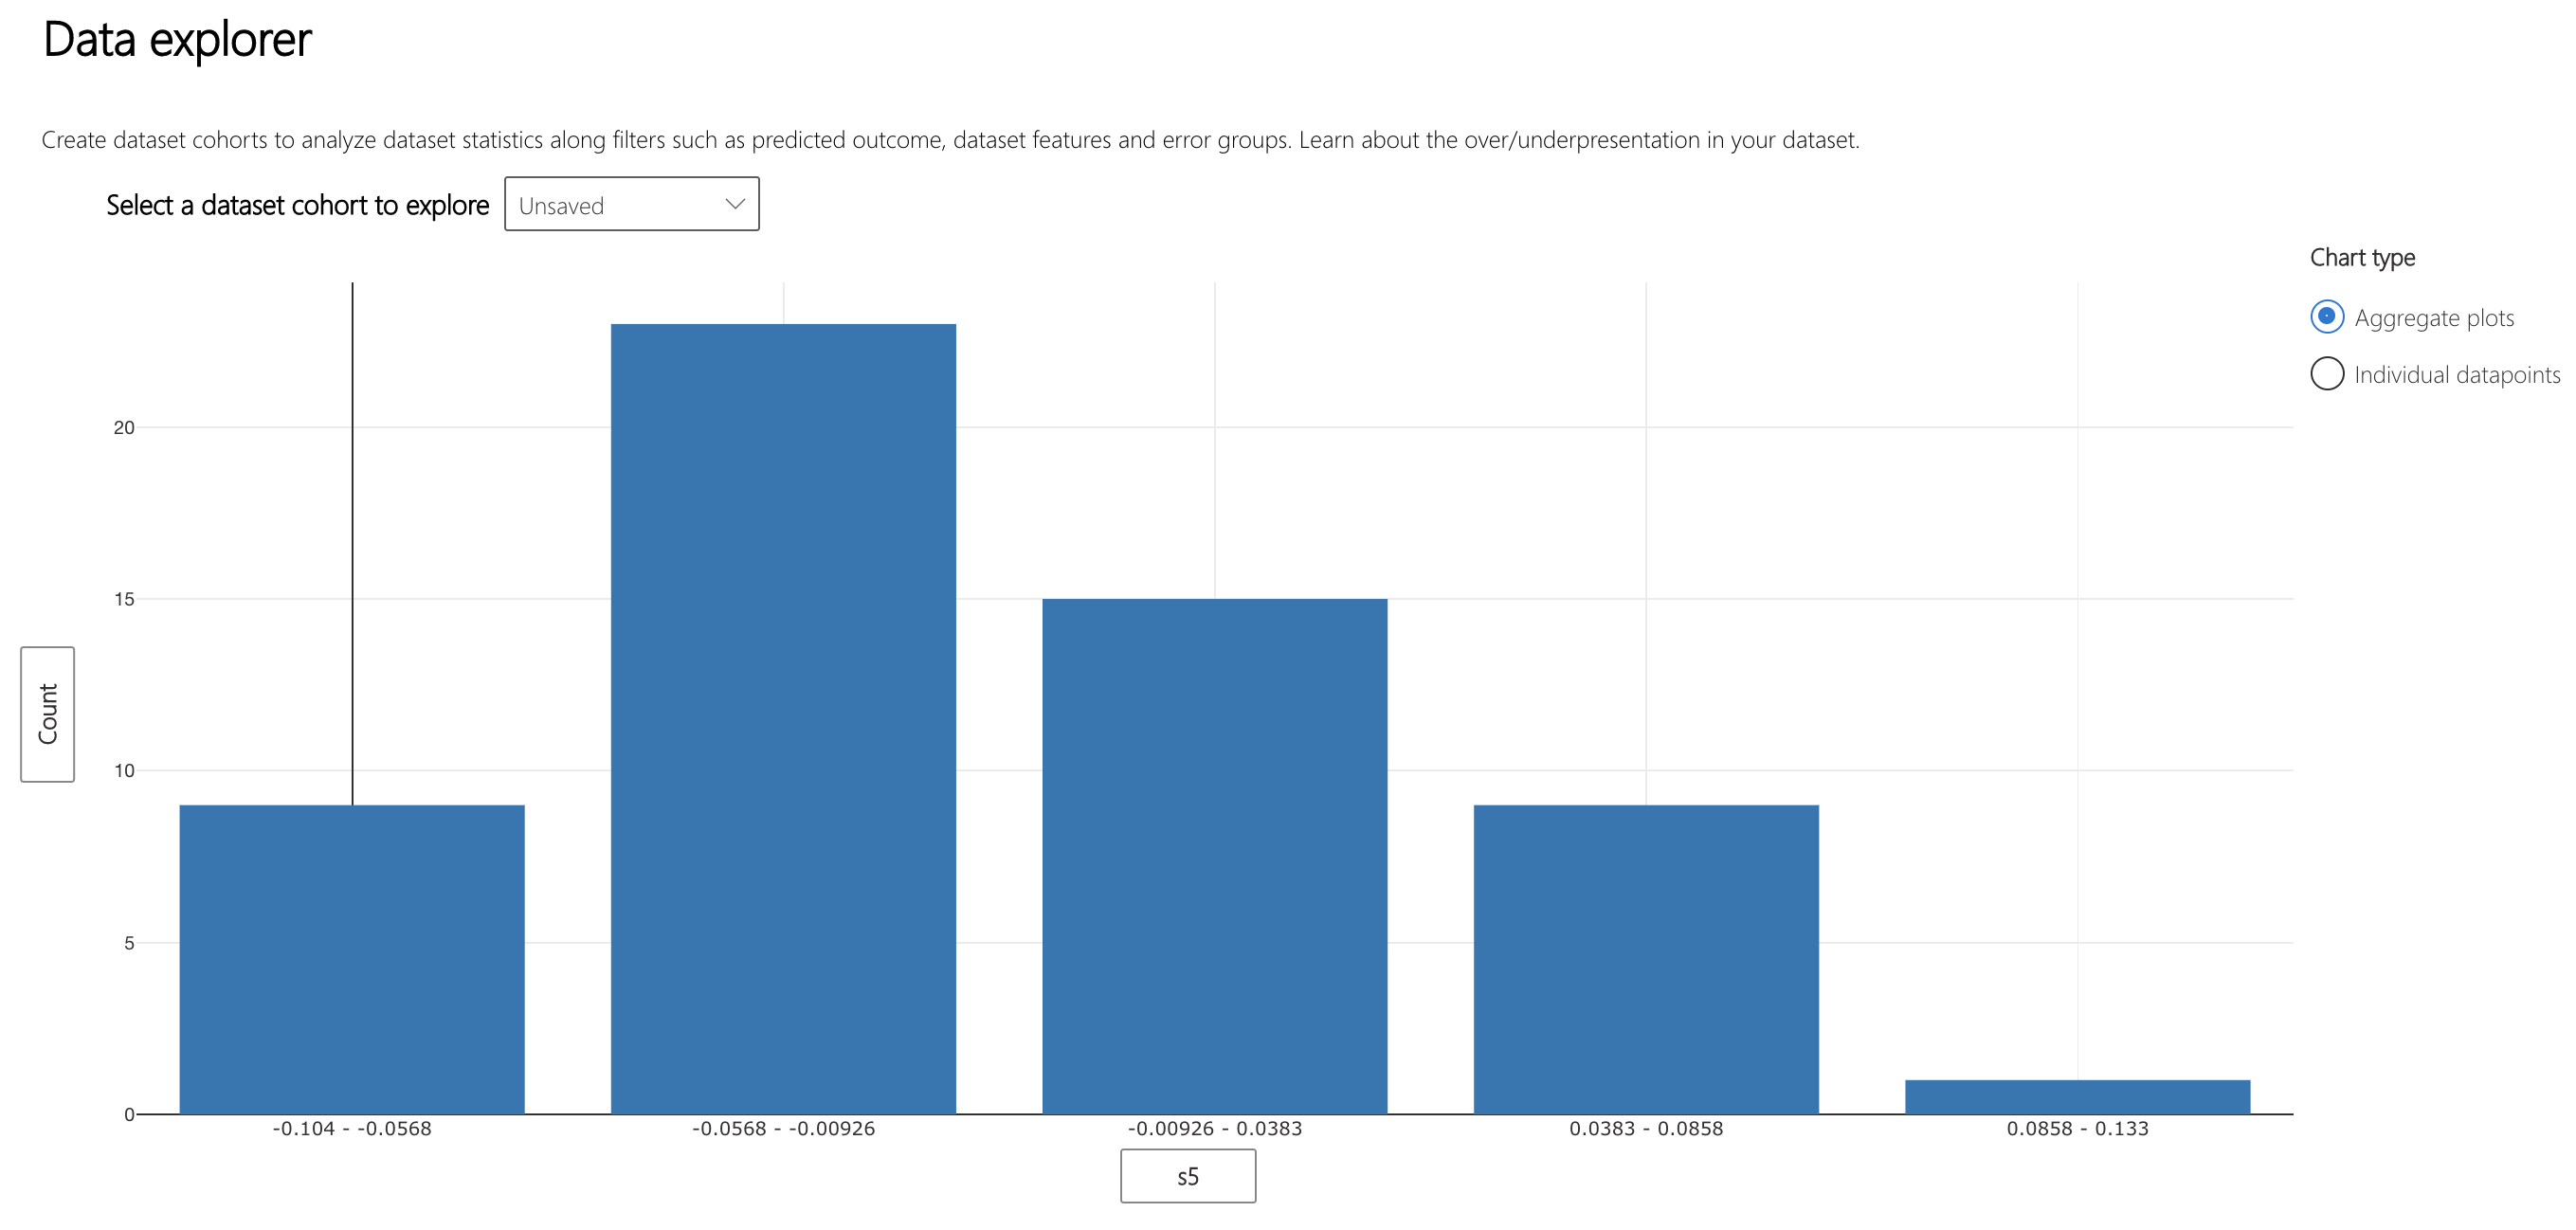

Moving on to understanding how the model makes decisions, the "Aggregate feature importance" plot on the Interpretability component lists the top features used across all datapoints in making predictions.

`s5` and `bmi`, body mass index, are the features that most influence the model's decisions.

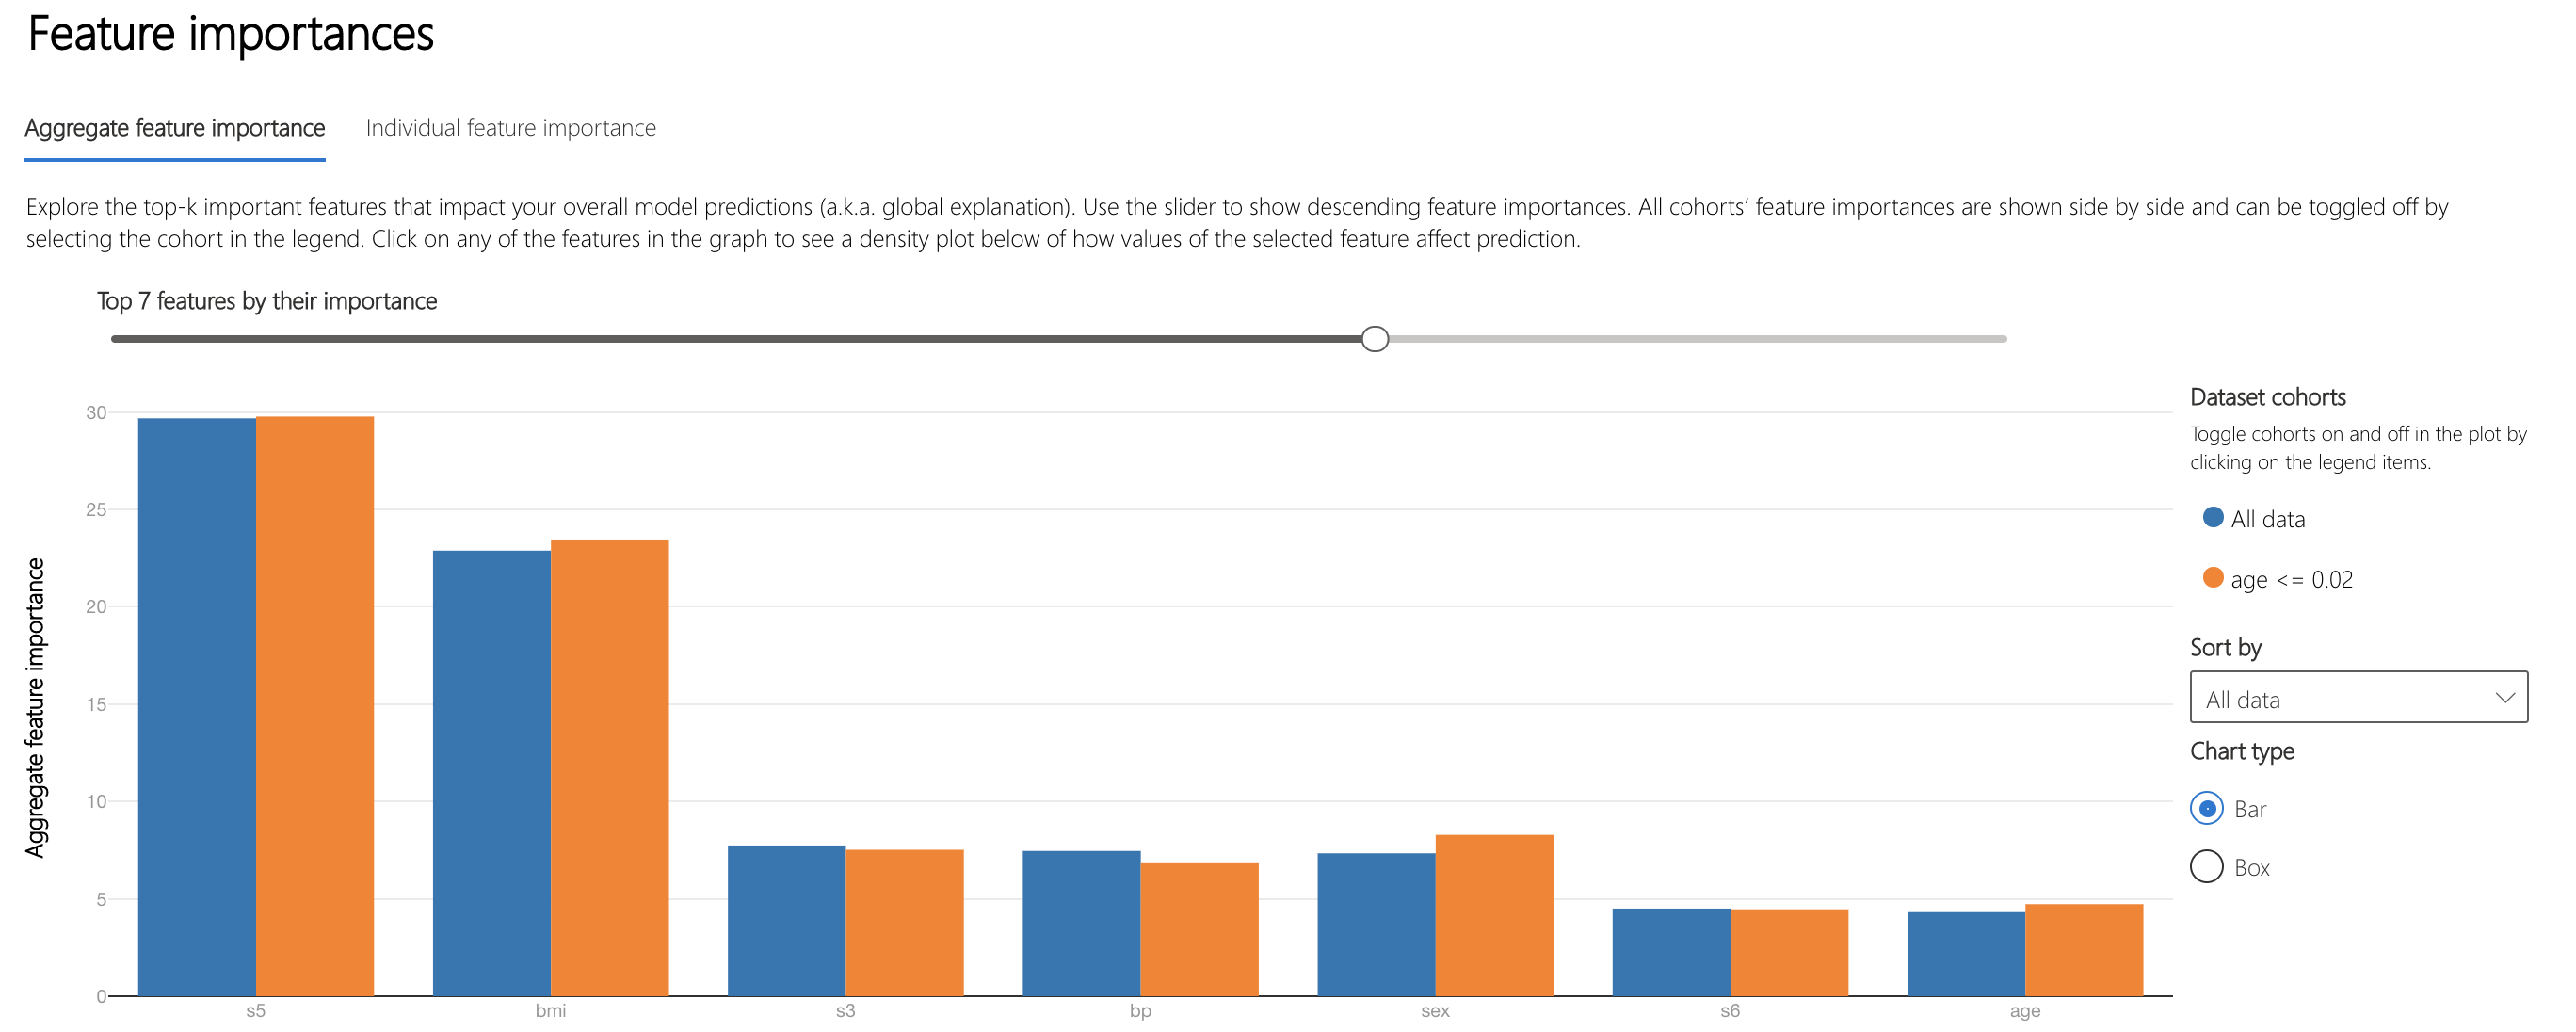

### Individual Analysis

The view of the Data Explorer component can be modified to display a scatterplot of various metrics on individual datapoints. Here, we see that the prediction with the largest magnitude negative error rate belongs to patient 13.

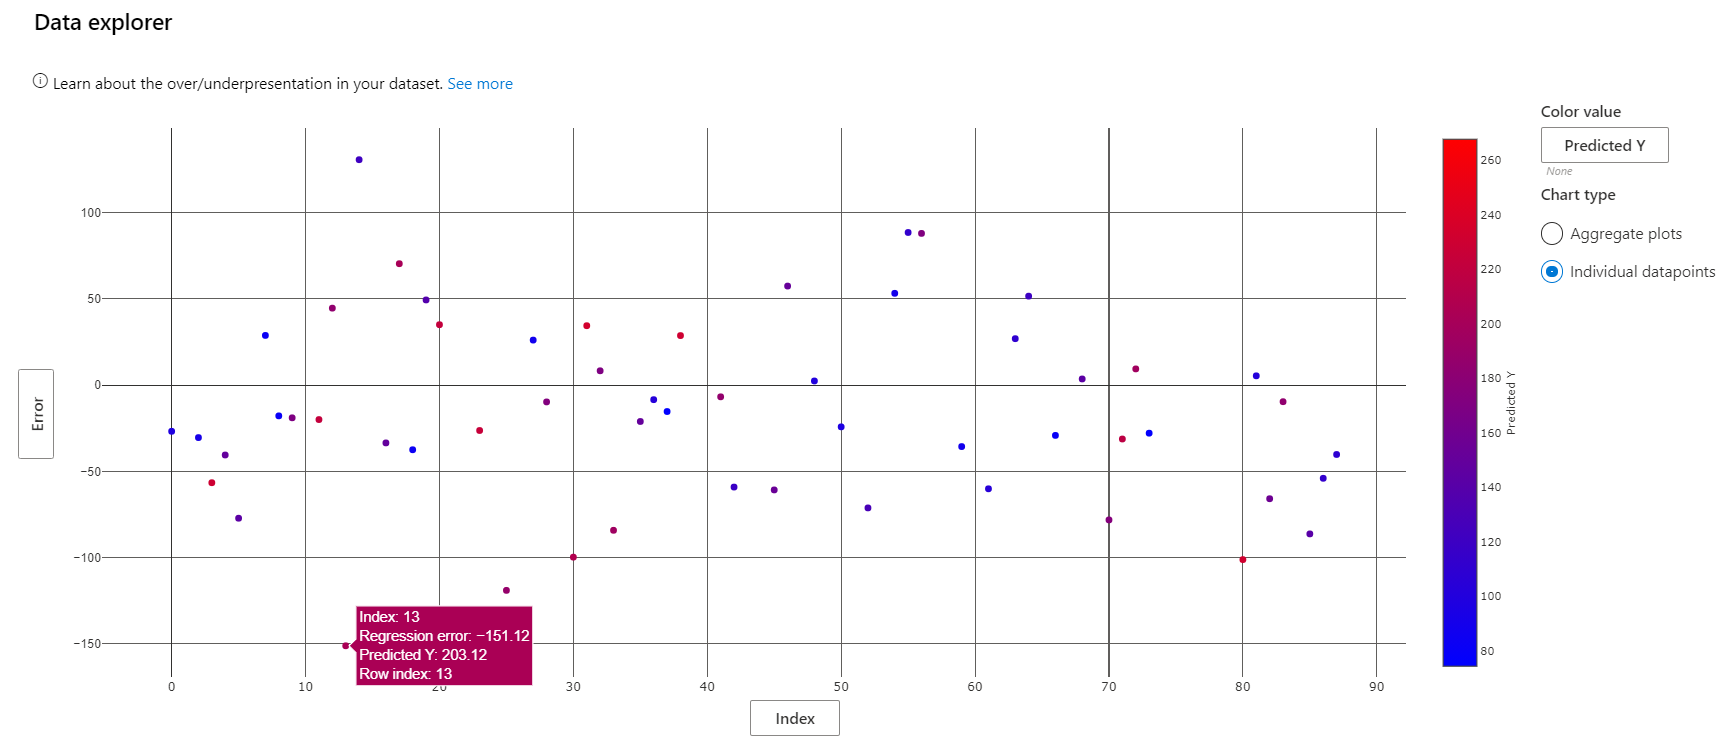

Patient 13's actual diabetes progression score is 52, barely a quarter of the model's prediction. How did the model go so wrong? Use the "Individual feature importance" to select the datapoint corresponding to this patient for further analysis.

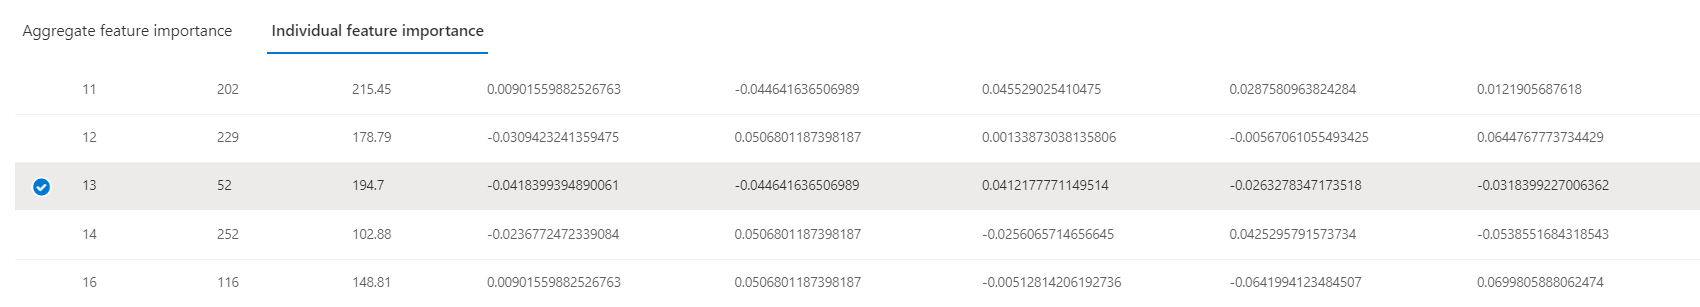

Scrolling lower, we can see that the model's prediction depended most on `s5`, like the average feature importances seen earlier.

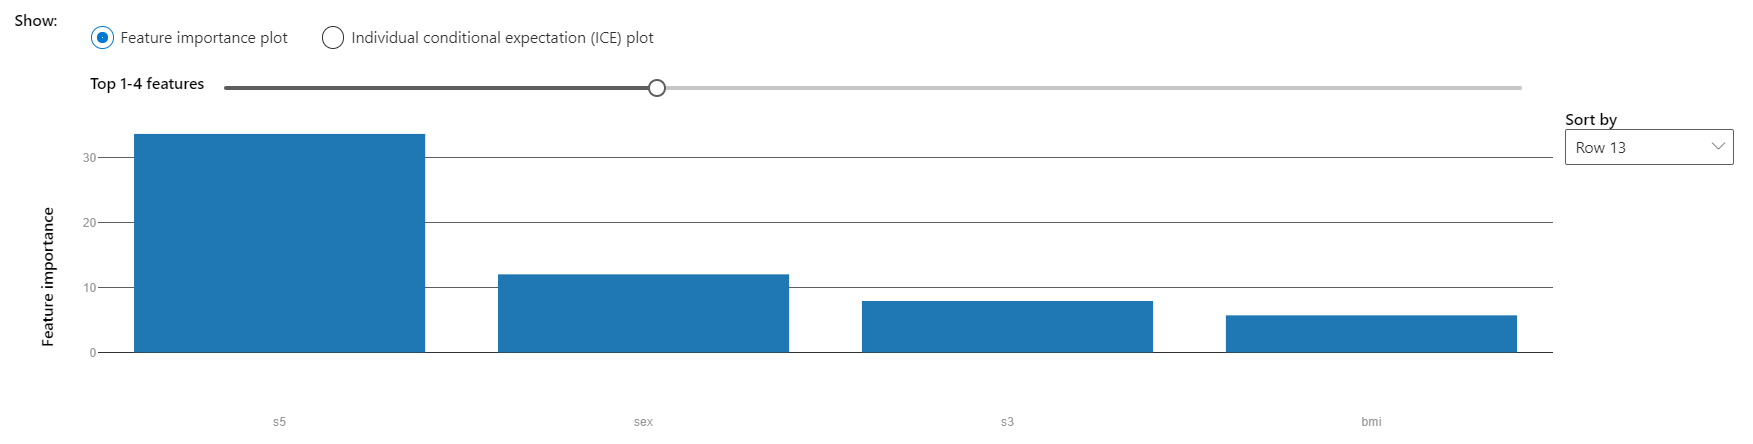

How would the model's prediction change if the `s5` value of this data point differed? There are two ways to explore the answer to this question.

The "Individual conditional expectation", or ICE plot, illustrates how the model's prediction for this point would have changed along a range of `s5` values. The point's `s5` value is approximately 0.03. This visualization shows that a lower `s5` value awould result in a significant decrease in the model's prediction.

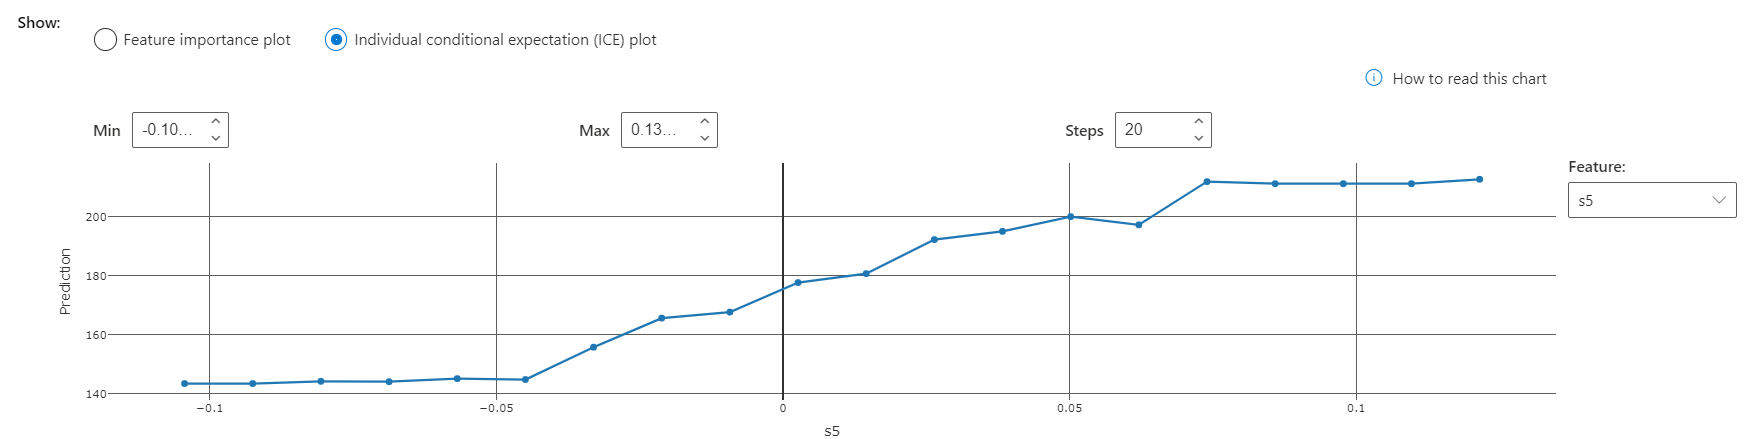

A similar analysis can be conducted elsewhere. The What-If Counterfactuals component is used to generate artificial points similar to a real point in the dataset, with the values of one or a few features set slightly differently. This can be used to understand how different feature combinations create different model outputs.

The top-ranked features plot of this component illustrates what changes in feature values would be most effective in moving the model prediction for patient 13 into the range specified when adding the counterfactual component to the dashboard (see code above).

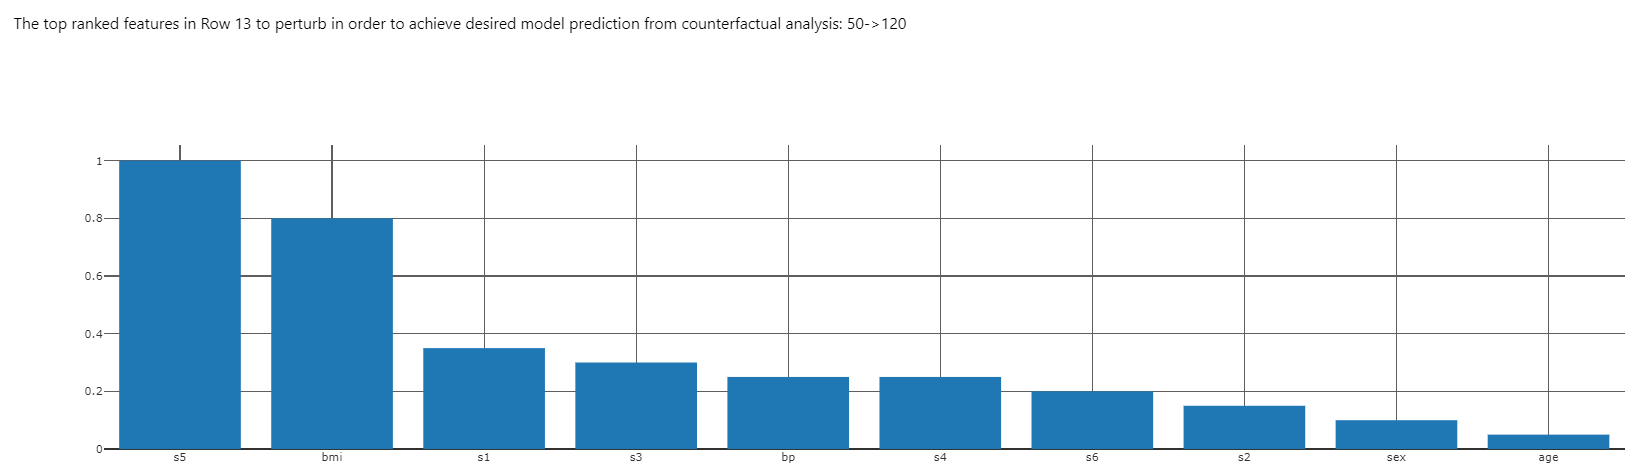

From the ICE plot, we know that decreasing `s5` will also decrease the model prediction. Let's see how changing `s5` and `bmi` together will shift the prediction. 

Select point 13 on the What-If Counterfactuals scatterplot and click "Create what-if counterfactual" to the right of the scatterplot. This brings up a side panel with sample counterfactuals and an option to create a new one.

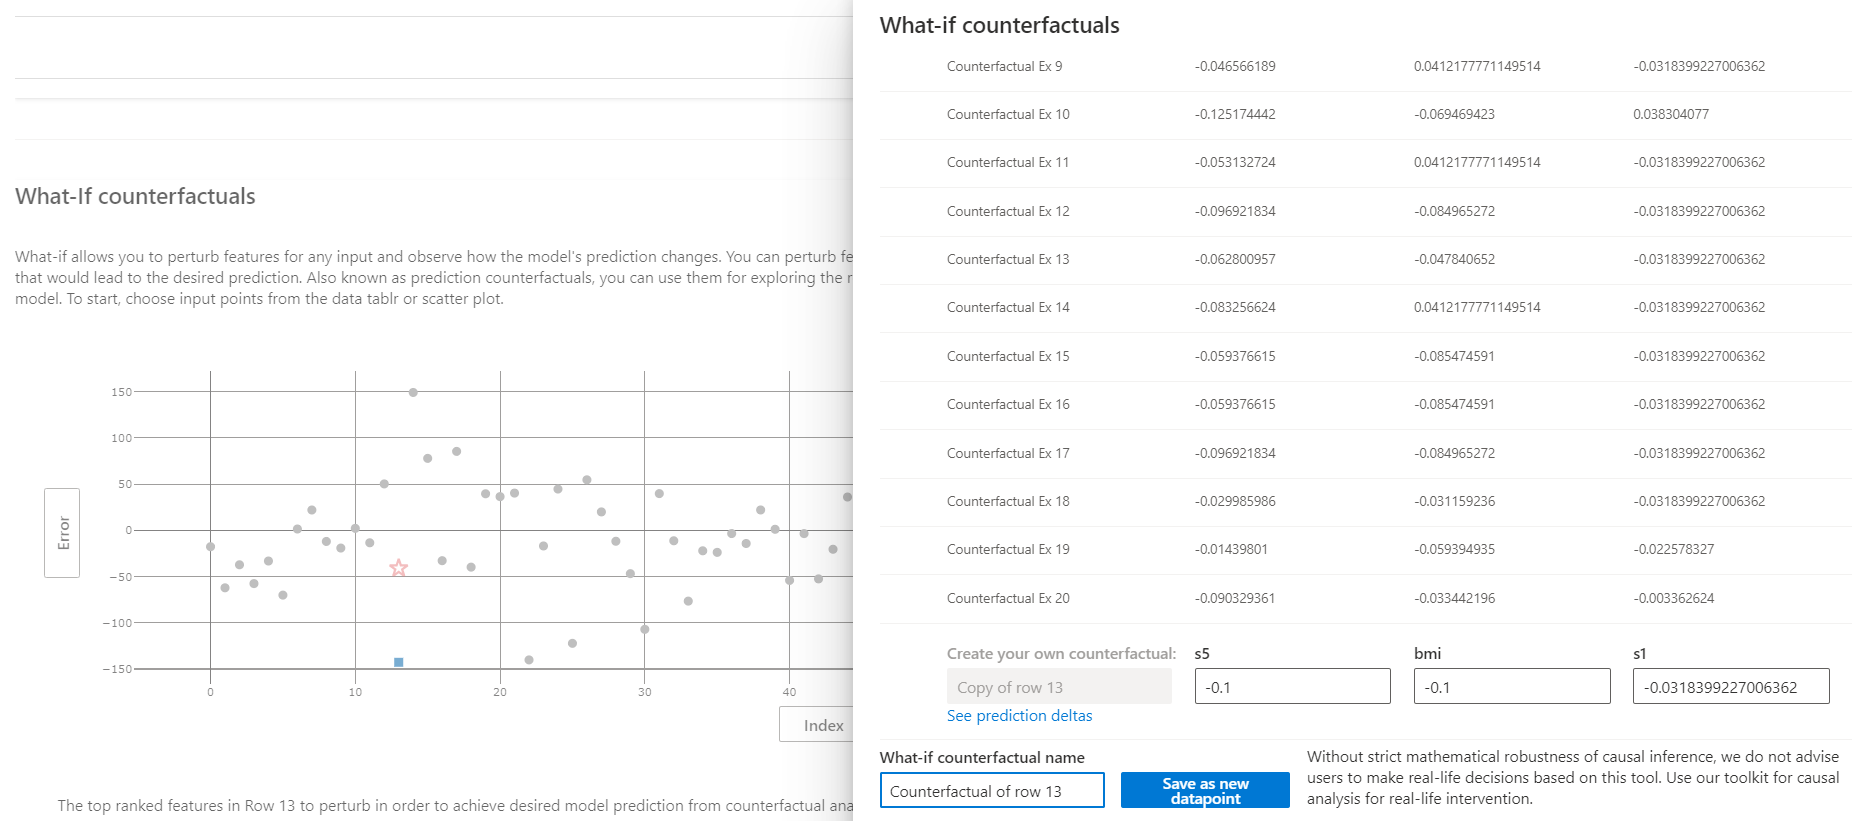

Creating a what-if counterfactual of point 13 with the value -0.1 for `s5` and `bmi` has the following result. We see that the magnitude of error drops from about 150 to about 50.

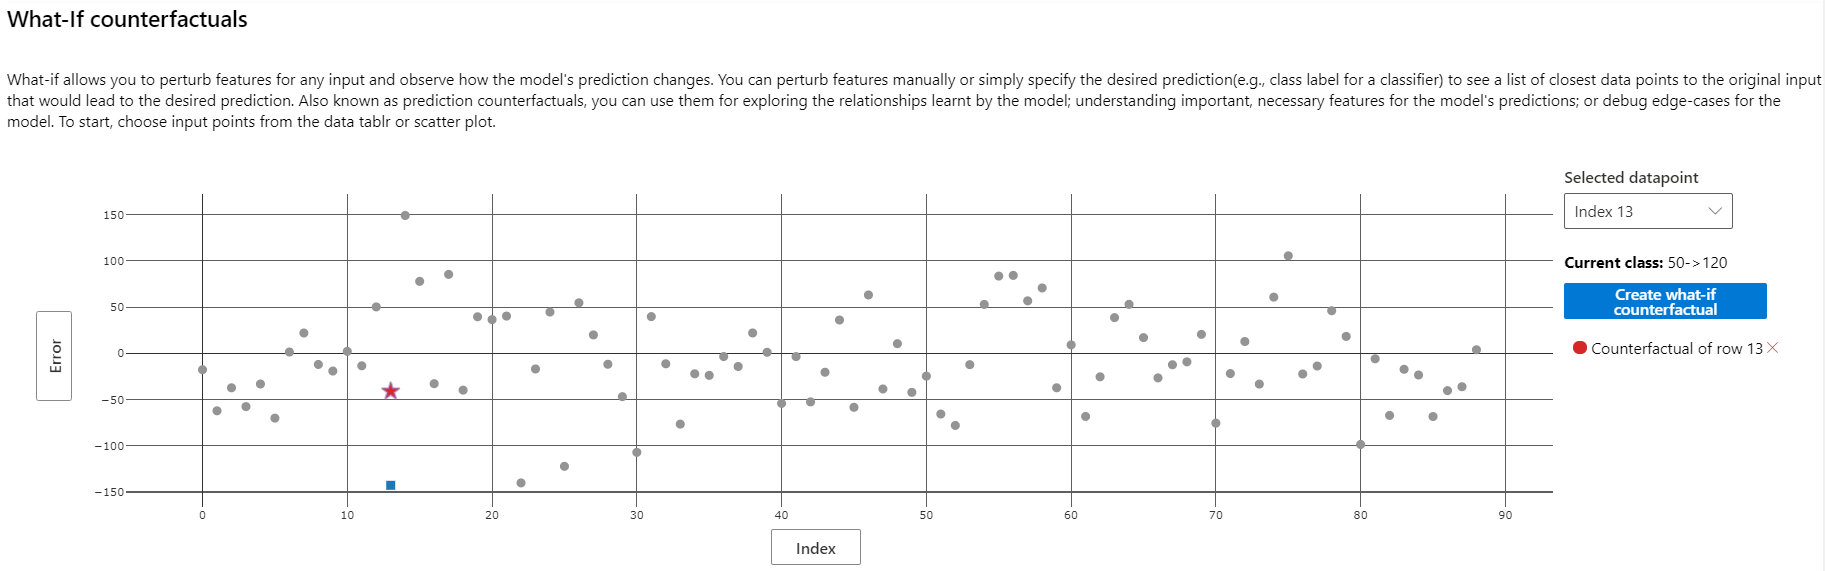